<a href="https://colab.research.google.com/github/karsarobert/Deep-Learning-2023/blob/main/04/PTE_DL4_ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning gyakorlat


## 4. gyakorlat: autoencoder hálók
### 2023. szeptrember 27.

## Anomália észlelés

## Áttekintés


Ebben a példában egy autoencodert képezünk ki az [ECG5000 adatkészlet](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000) anomáliáinak észlelésére. Ez az adatkészlet 5000 [Elektrokardiogramot](https://en.wikipedia.org/wiki/Electrocardiography) tartalmaz, mindegyik 140 adatponttal. Az adatkészlet egyszerűsített változatát fogja használni, ahol minden egyes példa vagy `0` (rendellenes ritmusnak megfelelő), vagy `1` (normális ritmusnak megfelelő) címkével van ellátva. Önt a rendellenes ritmusok azonosítása érdekli.

Megjegyzés: Ez egy címkézett adathalmaz, így ezt felügyelt tanulási problémaként is megfogalmazhatjuk. A példa célja, hogy bemutassa az anomália-felismerési koncepciókat, amelyeket nagyobb adathalmazokra is alkalmazhat, ahol nem állnak rendelkezésre címkék (például, ha sok ezer normális ritmus, és csak kis számú abnormális ritmus áll rendelkezésre).

Hogyan fogsz anomáliákat észlelni egy autoencoder segítségével? Emlékezzünk vissza, hogy az autoencoder úgy van betanítva, hogy minimalizálja a rekonstrukciós hibát. Az autoencodert csak a normális ritmusokon fogja betanítani, majd az összes adat rekonstruálására fogja használni. A hipotézisünk az, hogy a rendellenes ritmusok nagyobb rekonstrukciós hibával fognak rendelkezni. Ezután egy ritmust anomáliának fog minősíteni, ha a rekonstrukciós hiba meghalad egy rögzített küszöbértéket.

forrás: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb#scrollTo=Ndo4ERqnwQOU

### EKG-adatok betöltése

Az adatkészlet a [timeseriesclassification.com] (http://www.timeseriesclassification.com/description.php?Dataset=ECG5000) adatbázisán alapul.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses


In [ ]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [ ]:
# Az utolsó oszlop tartalmazza cimkéket,
labels = raw_data[:, -1]

# a többi oszlopban adatok vannak
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

Adatok normalizálása `[0,1]`.


In [ ]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

Az autoencodert csak a normál EKG adatokkal felhasználásával fogja betanítani, amelyek 1 cimkével rendelkeznek az adathalmazban. Válassza szét a normál adatokat az abnormális adatokat tartalmazó EKG adatoktól.

In [ ]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels] #itt csak a True indexű adatokat választjuk ki
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels] # itt pedig a False cimkével rendelkezőket
anomalous_test_data = test_data[~test_labels]

Normál EKG kirajzolása

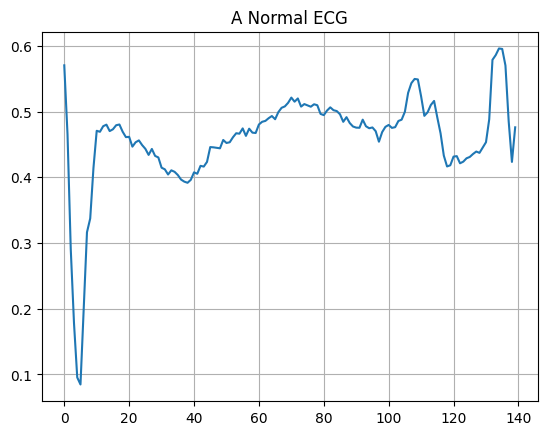

In [ ]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

Plot an anomalous ECG.

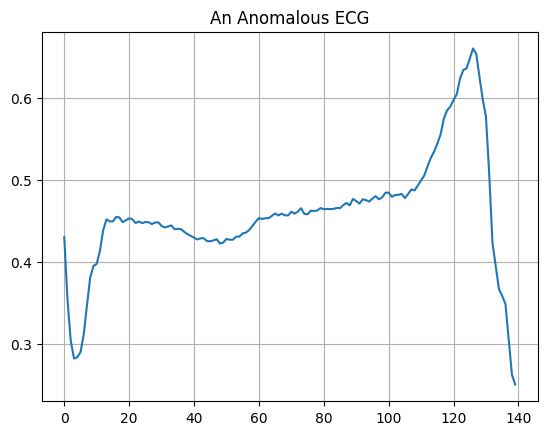

In [ ]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

# A modell felépítése

In [ ]:
autoencoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu", kernel_initializer= 'he_normal', input_shape=(140,)),
      layers.Dense(16, activation="relu", kernel_initializer= 'he_normal'),
      layers.Dense(8, activation="relu", kernel_initializer= 'he_normal'), #bottleneck
      layers.Dense(16, activation="relu", kernel_initializer= 'he_normal'),
      layers.Dense(32, activation="relu", kernel_initializer= 'he_normal'),
      layers.Dense(140, activation="sigmoid")]) #


In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

Vegyük észre, hogy az autoencodert a normál EKG-k felhasználásával képezzük, de a teljes tesztkészletet használva értékeljük ki.

In [ ]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=50,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/50
5/5 [==============================] - 2s 54ms/step - loss: 0.0626 - val_loss: 0.0535
Epoch 2/50
5/5 [==============================] - 0s 15ms/step - loss: 0.0551 - val_loss: 0.0524
Epoch 3/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0524 - val_loss: 0.0501
Epoch 4/50
5/5 [==============================] - 0s 15ms/step - loss: 0.0484 - val_loss: 0.0482
Epoch 5/50
5/5 [==============================] - 0s 10ms/step - loss: 0.0447 - val_loss: 0.0468
Epoch 6/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0411 - val_loss: 0.0443
Epoch 7/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0375 - val_loss: 0.0422
Epoch 8/50
5/5 [==============================] - 0s 18ms/step - loss: 0.0344 - val_loss: 0.0412
Epoch 9/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0317 - val_loss: 0.0400
Epoch 10/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0295 - val_loss: 0.0386
Epoch 11/50
5/5 [============

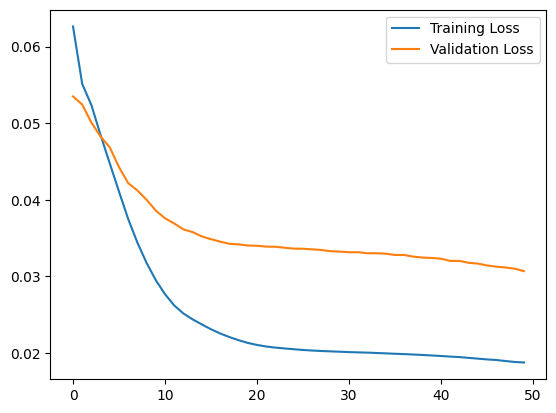

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

A következőkben anomáliának fogunk minősíteni egy EKG-t, ha a rekonstrukciós hiba nagyobb, mint egy standard eltérés a normál képzési példákhoz képest. Először is ábrázoljunk egy normál EKG-t a gyakorlókészletből, a rekonstrukciót, miután azt az autokódoló kódolta és dekódolta, valamint a rekonstrukciós hibát.

Itt létrehozunk egy encodert és decodert az eredeti modell segítségével!

In [ ]:
encoder = tf.keras.Sequential([layers.Dense(32, activation="relu",  input_shape=(140,), weights=autoencoder.layers[0].weights,),
      layers.Dense(16, activation="relu", weights=autoencoder.layers[1].weights ),
      layers.Dense(8, activation="relu", weights= autoencoder.layers[2].weights)])

decoder = tf.keras.Sequential([layers.Dense(16, activation="relu", weights=autoencoder.layers[3].weights),
      layers.Dense(32, activation="relu", weights = autoencoder.layers[4].weights),
      layers.Dense(140, activation="sigmoid", weights = autoencoder.layers[5].weights )])

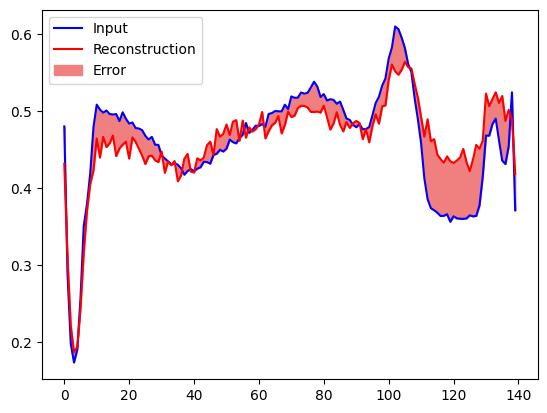

In [ ]:
encoded_data = encoder(normal_test_data).numpy() # az összes test adatot kódoljuk
decoded_data = decoder(encoded_data).numpy() # majd a kódolt adatból visszaállítjuk a dekóder segítségével az adatokat

plt.plot(normal_test_data[0], 'b') # a 0. test adatot kirajzoljuk
plt.plot(decoded_data[0], 'r') # a visszaállított adatot is kirajzoljuk
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Az előzőekhez hasonlóan kirajzolunk egy adatot az anomáliás halmazból

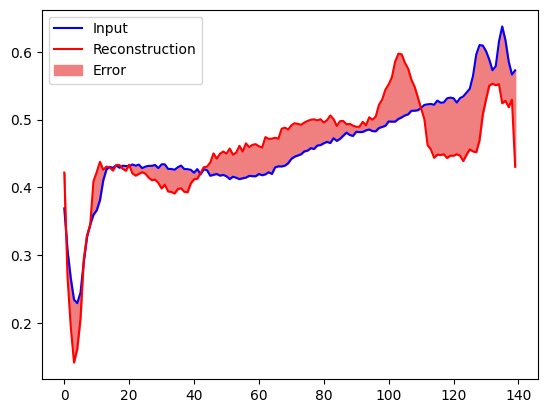

In [ ]:
encoded_data = encoder(anomalous_test_data).numpy()
decoded_data = decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Anomália észlelése

Az anomáliák észlelése úgy történik, hogy kiszámítjuk, hogy a rekonstrukciós veszteség nagyobb-e egy rögzített küszöbértéknél. Elöször kiszámítjuk a normál példák átlagos átlagos hibáját a képzési halmazból, majd a jövőbeli példákat rendellenesnek minősíti, ha a rekonstrukciós hiba nagyobb, mint egy standard eltérés a képzési halmazhoz képest.


A rekonstrukciós hiba ábrázolása a normál EKG-ken a gyakorló készletből

74/74 [==============================] - 0s 1ms/step


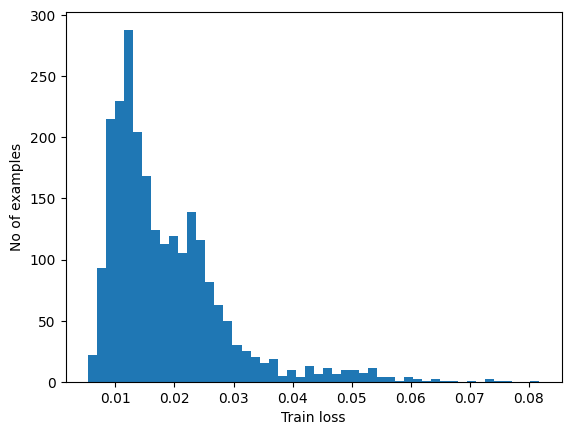

In [ ]:
reconstructions = autoencoder.predict(normal_train_data) # a tréning halmazra elkészítjük a 'predikciókat' visszaállított adatokat
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data) # majd kiszámítjuk ezek átlagos abszolút hibáit

plt.hist(train_loss[None,:], bins=50) # a kiszámított átlagos hibák eloszlását ábrázoljuk
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Választunk egy olyan küszöbértéket, amely egy szórással az átlag felett van. (átlag+szórás)

In [ ]:
threshold = np.mean(train_loss) + 2*np.std(train_loss) # itt már két szórásnyi mennyiséget vettünk!!!
print("Threshold: ", threshold)

Threshold:  0.03871995583176613


Megjegyzés: Más stratégiákat is használhatunk annak a küszöbértéknek a kiválasztására, amely felett a tesztpéldákat rendellenesnek kell minősíteni, a helyes megközelítés az adatállományától függ.

Ha megvizsgálja a tesztkészlet anomális példáinak rekonstrukciós hibáját, észreveheti, hogy a legtöbb esetben a rekonstrukciós hiba nagyobb, mint a küszöbérték. A küszöbérték változtatásával beállíthatja az osztályozó [pontosságát](https://developers.google.com/machine-learning/glossary#precision) és [visszahívását](https://developers.google.com/machine-learning/glossary#recall).

14/14 [==============================] - 0s 1ms/step


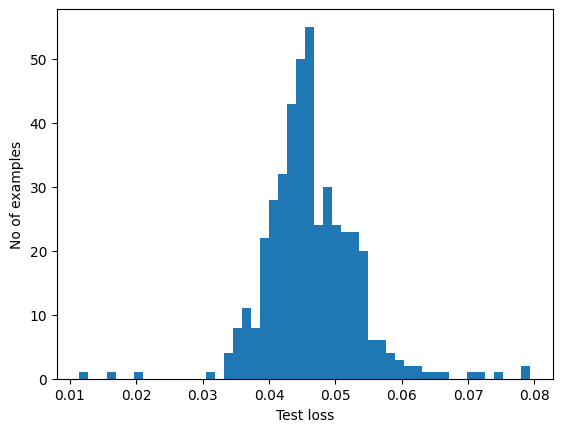

In [ ]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

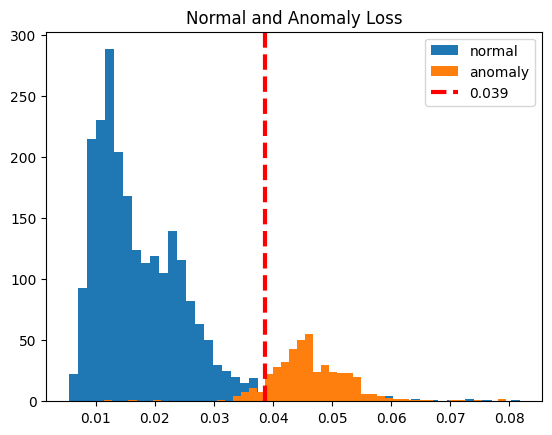

In [ ]:
plt.hist(train_loss, bins=50, label='normal')
plt.hist(test_loss, bins=50, label='anomaly')
plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))
plt.legend(loc='upper right')
plt.title("Normal and Anomaly Loss")
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.941
Precision = 0.9387040280210157
Recall = 0.9571428571428572


![](https://wikimedia.org/api/rest_v1/media/math/render/svg/7588abeafe63ab4b8ae63f954978186276e54d01)

![](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/525px-Precisionrecall.svg.png)